Train Frequentist CNN models on Strong Lensing Space Set 1 using FastAI.

###Google Colab Stuff

The stuff below is needed to clone a private Github repo from colab

In [4]:
import os
os.chdir('/content')

from google.colab import files

uploaded = files.upload()

!ls

Saving ssh.tar.gz to ssh.tar.gz
sample_data  ssh.tar.gz


In [5]:
#Remove the .ssh Folder if it already exists
!rm -rf /root/.ssh

#Create a new .ssh folder
!mkdir /root/.ssh

#Unzip the archive file
!tar xzvf ssh.tar.gz

#Copy the files to /root/.ssh
!cp ssh-colab/* /root/.ssh && rm -rf ssh-colab && rm -rf ssh.tar.gz
!chmod 700 /root/.ssh

#Add the git server as a ssh known host
!touch /root/.ssh/known_hosts
!ssh-keyscan github.com >> /root/.ssh/known_hosts
!chmod 644 /root/.ssh/known_hosts

ssh-colab/
ssh-colab/id_rsa_colab
ssh-colab/config
ssh-colab/id_rsa_colab.pub
# github.com:22 SSH-2.0-babeld-6c2374e6
# github.com:22 SSH-2.0-babeld-6c2374e6
# github.com:22 SSH-2.0-babeld-6c2374e6


In [6]:
#Run the agent, then run `ssh-add /root/.ssh/id_rsa_colab` in the prompt, optionally followed by `ssh-add -l` to verify, finally type `exit`
!ssh-agent /bin/bash

bash: cannot set terminal process group (141): Inappropriate ioctl for device
bash: no job control in this shell
]0;root@e3f87f9e9402: /contentroot@e3f87f9e9402:/content# ssh-add /root/.ssh/id_rsa_colab
Identity added: /root/.ssh/id_rsa_colab (pankajb64@gmail.com)
]0;root@e3f87f9e9402: /contentroot@e3f87f9e9402:/content# exit
exit


You'll need to set this to your github username and email.

In [0]:
!git config --global user.email "pankajb64@gmail.com"
!git config --global user.name "pankajb64"

In [8]:
!git clone git@github.com:deepskies/stronglensbnns.git

Cloning into 'stronglensbnns'...
remote: Enumerating objects: 409, done.
remote: Counting objects: 100% (409/409), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 409 (delta 164), reused 390 (delta 145), pack-reused 0
Receiving objects: 100% (409/409), 7.00 MiB | 32.01 MiB/s, done.
Resolving deltas: 100% (164/164), done.


In [7]:
!cd stronglensbnns/ && git pull

Already up to date.


### Download dataset

Need permissions to store data onto drive.

In [0]:
from google.colab import auth
auth.authenticate_user()

In [10]:
!gsutil  -m cp  gs://strong_lens_challenge/Space_set_1/SpaceBasedChallenge.1.tar.gz stronglensbnns/data/

Copying gs://strong_lens_challenge/Space_set_1/SpaceBasedChallenge.1.tar.gz...
\ [1/1 files][  3.6 GiB/  3.6 GiB] 100% Done  70.8 MiB/s ETA 00:00:00           
Operation completed over 1 objects/3.6 GiB.                                      


In [11]:
!gsutil cp gs://strong_lens_challenge/Space_set_1/euclidB_image_catalog.csv stronglensbnns/data/

Copying gs://strong_lens_challenge/Space_set_1/euclidB_image_catalog.csv...
/ [1 files][ 11.1 MiB/ 11.1 MiB]                                                
Operation completed over 1 objects/11.1 MiB.                                     


In [0]:
!cd stronglensbnns/data && tar xf SpaceBasedChallenge.1.tar.gz && rm -rf SpaceBasedChallenge.1.tar.gz

In [0]:
!cd stronglensbnns/data && mkdir -p Space_set_1 && mv Data_* Space_set_1 && rm README

In [13]:
!cd stronglensbnns/data && ls

bayesiancnn  ensai  euclidB_image_catalog.csv  Space_set_1


### Begin Notebook

In [0]:
from fastai.vision import *
from pathlib import Path
from astropy.io import fits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn

import os

In [0]:
#add the  bayesiancnnn and ensai src to import path - https://stackoverflow.com/a/35273613/7154530
bcnn_module_path = os.path.abspath(os.path.join('stronglensbnns/src/bayesiancnn'))
if bcnn_module_path not in sys.path:
    sys.path.append(bcnn_module_path)
    
ensai_module_path = os.path.abspath(os.path.join('stronglensbnns/src/ensai'))
if ensai_module_path not in sys.path:
    sys.path.append(ensai_module_path)

We consider instances where `numb_pix_lensed_image` is between 100 and 500 as valid. We also use scaled log of einstein area as our label.

In [16]:
df = pd.read_csv('stronglensbnns/data/euclidB_image_catalog.csv', skiprows=24)
df_lens = df.loc[(df['numb_pix_lensed_image'] > 100) & (df['numb_pix_lensed_image'] < 500)]
df_lens['scaled_log_ein_area'] = np.log(df_lens['Einstein_area']) + np.log(2e10)
df_lens['scaled_ein_area'] = df_lens['Einstein_area']*1e9

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Convert FITS images to JPG to alow FastAI to process them.

In [0]:
dirs = ['stronglensbnns/data/Space_set_1/{}'.format(d) for d in os.listdir('stronglensbnns/data/Space_set_1/') if 'Data' in d]

In [0]:
files = []
for d in dirs:
    fits_dir = '{}/Public/Band1'.format(d)
    jpg_dir = '{}/Public_jpg/Band1'.format(d)
    os.makedirs(jpg_dir, exist_ok=True)
    for f in os.listdir(fits_dir):
        fname = fits_dir + '/' + f
        ar = fits.open(fname)[0].data
        id = int(fname.split('-')[1].split('.')[0])
        fj = '{}/{}.jpg'.format(jpg_dir, id)
        plt.imsave(fj, ar)
        files.append(fj)
        

In [0]:
df_files = pd.DataFrame()
df_files['fname'] = files
df_files['ID'] = [int(os.path.splitext(os.path.basename(fname))[0]) for fname in files]

df_merge = pd.merge(df_lens, df_files, on='ID')

In [20]:
df_merge.head()

,ID,x_crit,y_crit,ID_source,z_source,EUC_VIS_mag_source,caustic_plane,caustic_index,z_caustic_plane,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma,num_lensed_images,magnification_eff,KiDS_noise_map,total_numb_pixels_sigma,flux_in_sigma,num_images,EUC_VIS_mag_lens,kids_lens_image,mobs_lens_imag,no_source,scaled_log_ein_area,scaled_ein_area,fname
0,186193,-0.004088,0.007850,4361,2.42,26.691,8,45369,1.5,1.814210e-09,276,801.745,2,15.68290,0,9047,219315.0,14,17.2585,0,1,0,3.591382,1.814210,stronglensbnns/data/Space_set_1/Data_EuclidBig...
1,116891,-0.001330,0.005507,3068,1.38,26.094,8,38977,1.5,1.577840e-10,483,1981.130,2,18.49040,0,3190,14748.9,541,20.7723,0,1,0,1.149204,0.157784,stronglensbnns/data/Space_set_1/Data_EuclidBig...
2,110511,-0.001330,0.005507,1738,2.57,26.298,8,38977,1.5,1.195500e-09,369,1562.670,3,11.92000,0,3523,14728.4,532,20.7233,0,1,0,3.174297,1.195500,stronglensbnns/data/Space_set_1/Data_EuclidBig...
3,113377,-0.001634,-0.000123,1626,1.38,25.601,8,21112,1.5,1.270680e-10,211,349.244,1,5.62326,0,5222,23615.8,267,19.9194,0,1,0,0.932699,0.127068,stronglensbnns/data/Space_set_1/Data_EuclidBig...
4,126021,-0.001634,-0.000123,6151,1.04,26.914,8,21112,1.5,4.869460e-11,125,289.163,2,11.02470,0,5295,25373.6,287,19.8887,0,1,0,-0.026455,0.048695,stronglensbnns/data/Space_set_1/Data_EuclidBig...


Create a `DataBunch` - a way to access training and validation set in FastAI. Transform it using standard image processing transforms - rotate, zoom, flip, etc. Resize the image to be 224x224 (needed for resnets)

**Normalize the image using Imagenet stats - this is important since the model is pre-trained on Imagenet.**

In [0]:
data = (ImageList
.from_df(path='', df=df_merge, cols='fname')
.split_by_rand_pct(seed=42)
.label_from_df(cols='scaled_log_ein_area',label_cls=FloatList)
.transform(get_transforms(), size=(224,224))
.databunch()
.normalize(imagenet_stats))

FastAI allows us to easily visualize a batch of training data and corresponding labels.

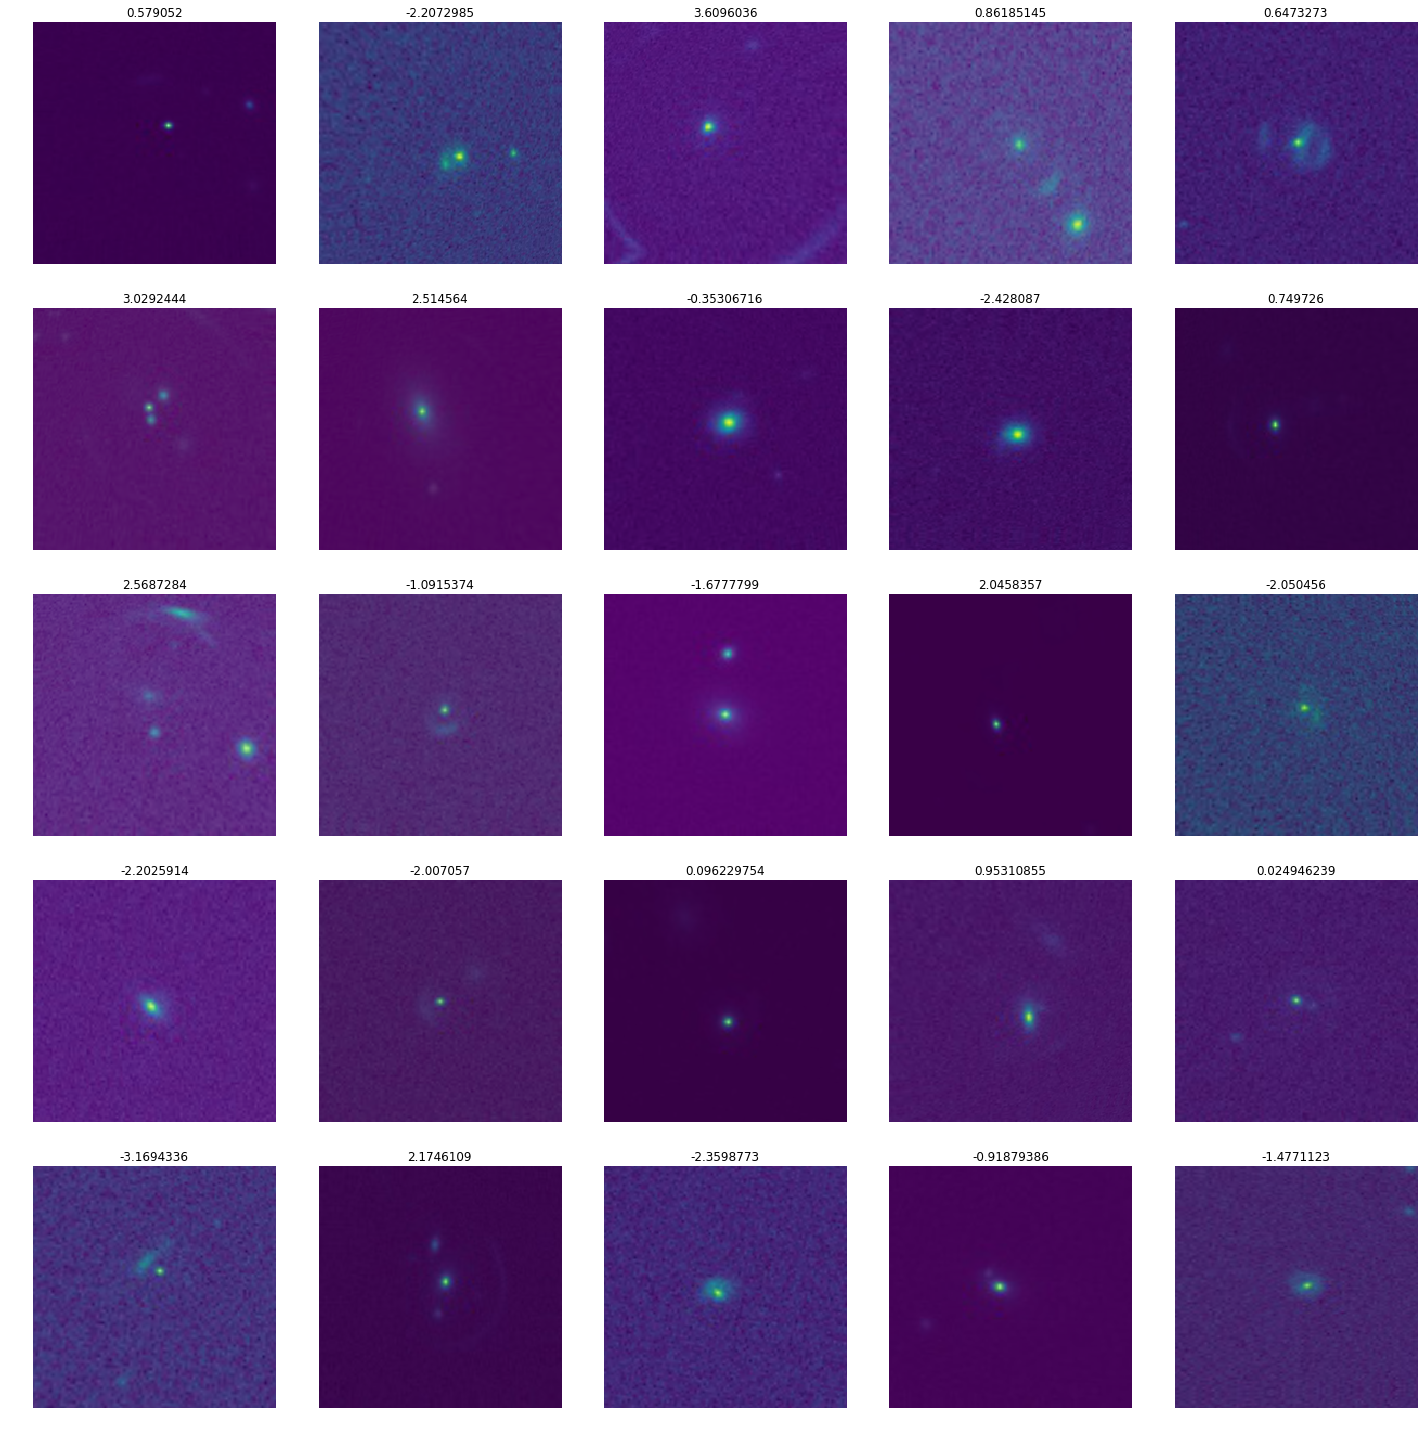

In [0]:
data.show_batch()

The way to train in FastAI is to create a learner object - here we create a `cnn_learner` which takes in a `DataBunch` (created above), a base model (Resnet18 in our case), metrics and any callbacks. `ShowGraph` is a useful callback that allows us to visualize the loss and any metrics evaluated during training and validation.

In [21]:
learn = cnn_learner(data, models.resnet18, callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 72362162.35it/s]


A really cool feature of FastAI is the learning rate finder, it tries out a bunch learning rates within a range (typically 1e-7 to 10) for a few iterations each and plots the loss as a function of learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


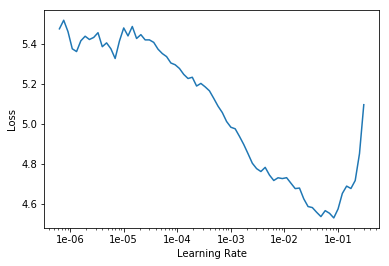

In [0]:
learn.lr_find()
learn.recorder.plot()

The creators of FastAI advise that we pick the learning rate corresponding to the steepest part of the curve. Its hard to know in the above case, I pick 5e-4

We can train by calling `learn.fit_one_cycle` - which fits the data, but for each epoch it varies the learning rate (from low to high and back to low). This is reported as giving better performance by FastAI creators. See https://sgugger.github.io/the-1cycle-policy.html for more details.

epoch,train_loss,valid_loss,time
0,2.391619,1.982411,01:10
1,1.631113,1.275132,01:09
2,1.539814,1.317649,01:09
3,1.326624,1.040123,01:09
4,1.258225,1.073518,01:09
5,1.081119,0.908452,01:09
6,1.048564,0.912014,01:09
7,0.881349,0.779259,01:09
8,0.888985,0.765525,01:09
9,0.796226,0.738969,01:09


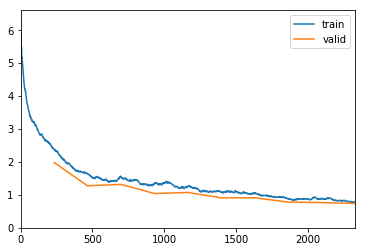

In [22]:
#@title
lr = 5e-2
learn.fit_one_cycle(10, slice(lr))

The above model was trained with the weights of the base model being "frozen" - they were not updated during the training. We may wanna train the entire model to fine-tune the performance.

For this we can "unfreeze" the model and tune all the weights. 

In [0]:
learn.unfreeze()

It is recommended the pre-trained weights (the top layers) be trained with a much smaller learning rates and they're mostly well trained. The bottom layers can be trained with a higher learning rate. FastAI allows us to specify differential learning rate - with the minimum learning rate applied to the top layer, the maximum applied to the bottom layers, and intermediate values applied to the layers in between.

epoch,train_loss,valid_loss,time
0,0.790336,0.738067,01:35
1,0.828994,0.733221,01:34
2,0.816590,0.733403,01:34
3,0.840992,0.716630,01:34
4,0.791319,0.738512,01:34
5,0.799730,0.725745,01:34
6,0.801089,0.703071,01:34
7,0.775274,0.715759,01:34
8,0.727872,0.685563,01:34
9,0.713635,0.693377,01:34


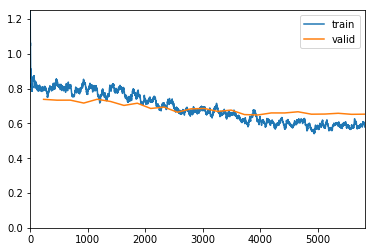

In [24]:
learn.fit_one_cycle(25, slice(1e-6, 5e-4))

It is also easy to view the model predictions on a validation set.

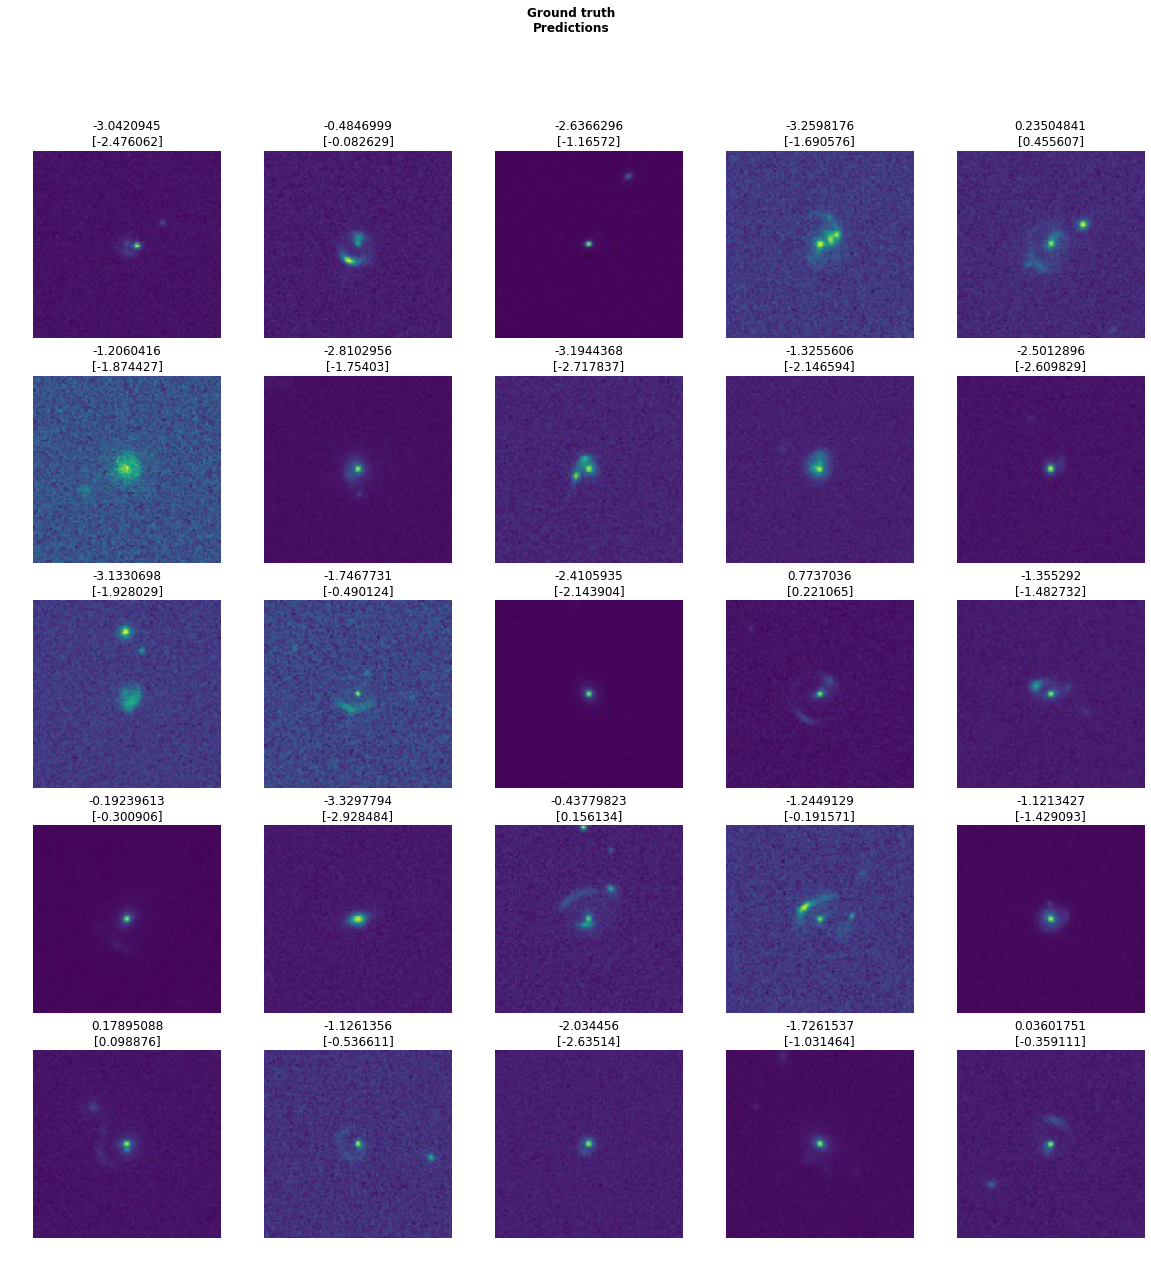

In [0]:
learn.show_results()

We can use the predictions to plot a scatter plot of ground truth vs predictions using the approach in the previous notebooks

In [0]:
trainset = data.train_ds
testset = data.valid_ds
trainloader = data.train_dl
testloader = data.valid_dl

In [0]:
target_sum = 0.0
target_count = 0
for _, targets in trainloader:
    print(targets.shape)
    target_sum += targets.detach().cpu().numpy().squeeze().sum()
    target_count += targets.shape[0]
train_mean = target_sum/target_count

In [0]:
def scatter_plots_f():
    preds, labs = learn.get_preds()
    print(preds.shape)
    print(labs.shape)
    #print(preds)
    #print(labs)
    #pt = torch.from_numpy(preds)
    #pl = torch.from_numpy(labs)
    #loss = criterion(pt, pl)
    #print('Loss: {}'.format(loss))
    #print(testY)
    fig, ax = plt.subplots(figsize=(15,6))
    points = [[-4, 4]]
    trainY_mean = train_mean
    lr = LinearRegression()
    lr.fit(labs.reshape(-1, 1), preds)
    pp = lr.predict(labs.reshape(-1, 1))  
    for j in range(1):
        sns.scatterplot(x=labs, y=preds.squeeze(), ax=ax)
        ax.plot(points[j], points[j], '--r', label='ideal relationship line')
        ax.plot(points[j], [trainY_mean, trainY_mean], '--g', label='line if predicting train mean')
        ax.plot(labs, pp, '--b', label='current relationship line')
        ax.set_xlabel('Einstein Area : true')
        ax.set_ylabel('Einstein Area : predicted')
        ax.set_xlim(points[j])
        ax.set_ylim(points[j])
        ax.legend()
    fig.suptitle('Scatter plots for true vs predicted values for the parameters')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    

torch.Size([3730, 1])
torch.Size([3730])


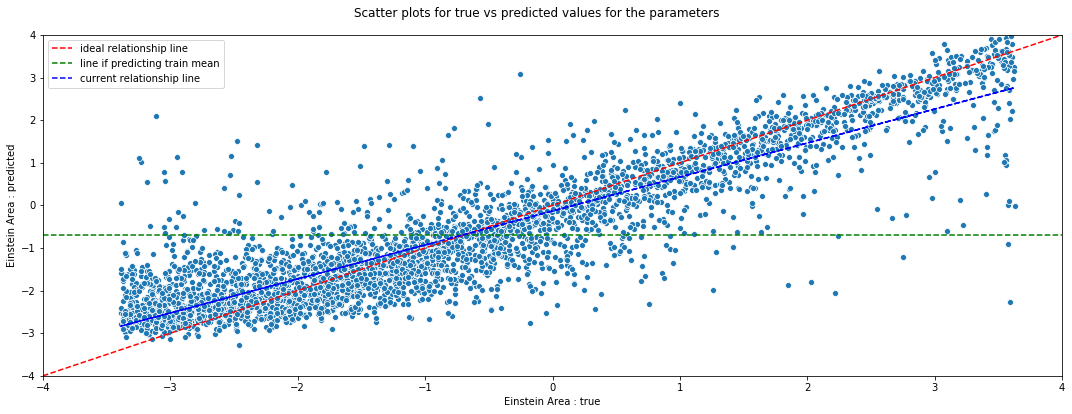

In [41]:
scatter_plots_f()